# Banking Channel Usage Analysis, Customer Segmentation, Forecasting

## Channel Analysis in Banking
Banks operate multiple channels such as ATMs, online banking, mobile apps, and POS systems. 
Understanding how customers use these channels is critical for cost optimization, digital transformation, 
and customer experience improvement.

This project analyzes transaction-level banking data to:
- Understand channel usage patterns
- Segment customers based on channel behavior
- Forecast future channel demand

**This first part of the project focuses on understanding how customers interact with banking channels and how banks can optimize digital adoption**

## 1. Import Libraries

In this section, I import the Python libraries required for data analysis, visualization, 
customer segmentation, and time-series forecasting.

In [113]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from prophet import Prophet

I will use Pandas and Numpy for data manipulation. Scikit-learn for segmentation, and Prophet for time-series forecasting. All required libraries have been successfully imported. The environment is now ready for data loading and analysis.

## Data Loading and Initial Inspection

In this section, I load the banking transaction dataset and perform an initial inspection to understand its structure, size, and available features. This step is critical to ensure data quality and to identify which variables are relevant for channel analysis and forecasting.

In [114]:
transactions = pd.read_csv("Data/bank_transactions_data.csv")
transactions.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


The dataset contains transactional-level banking data, including transaction
amounts, channels used, customer demographics, and behavioral indicators.
Each row represents a single banking transaction.

## 3. Initial Data Understanding

In this section, I inspect the structure of the dataset to understand available columns, data types, and the overall shape of the data.

In [115]:
#Data Structure of transactions
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

Before I begin modelling, I have explored the datasets to understand available features and potential use cases 

Key columns used in this analysis include:

- **TransactionID:** Unique identifier for each transaction
- **AccountID:** Customer account identifier
- **TransactionAmount:** Monetary value of the transaction
- **TransactionDate:** Timestamp of the transaction
- **Channel:** Banking channel used (ATM, Online, Branch)
- **CustomerAge:** Age of the customer
- **TransactionDuration:** Time taken to complete transaction

# Key details about transactions data frame:
- **Total Entries:** 2512, ranging from index 0 to 2511
- **Total Columns:** 16 columns
- **-Non-Null Counts:** their is no missing values in this dataframe, all column have 2512 entries
- **Data Types**: I am working with threee data types

        - 2columns(**TransactionAmount, AccountBalance**): float64 types
        - 3columns(**CustomerAge,TransactionDuration,LoginAttempts**): int64 types
        -11columns: (**the rest are objects of type string**)

**I validated data quality by checking data types and missing values before feature engineering.**

## 6. Date Formatting

Transaction timestamps are converted to datetime format to support trend analysis and forecasting.

In [116]:
transactions["TransactionDate"] = pd.to_datetime(transactions["TransactionDate"])

## 7.Channel Usage Overview

Here,I analyze how customers interact with the bank across different channels (ATM, Online, and Branch). Understanding channel distribution helps the bank assess customer preferences and allocate resources effectively.


In [117]:
channel_counts = (
    transactions.groupby("Channel")
    .size()
    .reset_index(name="transaction_count")
)

channel_counts

,Channel,transaction_count
0,ATM,833
1,Branch,868
2,Online,811


# Banking Channel Distribution Explanation
Branch transactions appear slightly more frequently than ATM and Online transactions, although usage across channels is relatively balanced.

# Channel Usage Visualisation

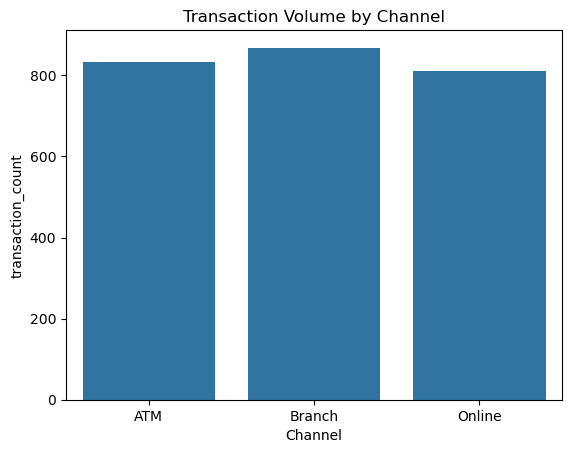

In [118]:
sns.barplot(
    data=channel_counts,
    x="Channel",
    y="transaction_count"
)
plt.title("Transaction Volume by Channel")
plt.show()

# Create Channel-Level Behavioral Metrics
## Channel-Level Transaction Profiling

This section summarizes key transaction metrics by channel, including transaction volume, total value, average transaction amount, and average transaction duration. The goal is to compare channel performance and customer behavior across ATM, Branch, and Online channels.

In [119]:
channel_metrics = transactions.groupby("Channel").agg(
    total_transactions=("TransactionID", "count"),
    total_amount=("TransactionAmount", "sum"),
    avg_amount=("TransactionAmount", "mean"),
    avg_duration=("TransactionDuration", "mean")
).reset_index()

channel_metrics

,Channel,total_transactions,total_amount,avg_amount,avg_duration
0,ATM,833,256331.43,307.720804,122.091236
1,Branch,868,250183.00,288.229263,116.675115
2,Online,811,241041.14,297.214723,120.305795


## Channel-Level Transaction Profiling Summary
The results reveal clear behavioral differences across channels. Branch transactions occur most frequently but involve lower average amounts, suggesting routine or service-oriented interactions. ATM transactions, while slightly less frequent, process the highest average and total amounts, indicating usage for higher-value cash withdrawals. Online transactions show balanced characteristics, supporting efficient medium-value transactions with moderate processing time.

# Channel Segmentation (K-Means)

In [120]:
segmentation_transactions = channel_metrics.drop(columns=["Channel"])
segmentation_transactions

,total_transactions,total_amount,avg_amount,avg_duration
0,833,256331.43,307.720804,122.091236
1,868,250183.00,288.229263,116.675115
2,811,241041.14,297.214723,120.305795


 ## Feature Scaling
Before applying clustering, numerical features are standardized to ensure that variables measured on different scales contribute equally to distance calculations. This prevents features with larger magnitudes from dominating the clustering process.
Feature scaling standardizes all variables to the same scale so that distance-based clustering algorithms capture behavioral differences rather than differences in measurement units

In [121]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(segmentation_transactions)
scaled_features

array([[-0.18462482,  1.13757715,  1.25532141,  1.06524521],
       [ 1.30657567,  0.15883679, -1.1916874 , -1.33819041],
       [-1.12195085, -1.29641394, -0.06363401,  0.2729452 ]])

### Interpretation of Channel Behavior

The analysis reveals that similar transaction volumes across channels mask fundamentally different usage patterns. ATM transactions are fewer but significantly higher in value and duration, indicating use for deliberate, high-value activities. Branch transactions occur most frequently but involve smaller values and shorter durations, suggesting routine or service-driven interactions. Online transactions display balanced characteristics, supporting moderate-value transactions with reasonable efficiency.

These findings highlight the importance of evaluating channel behavior across multiple dimensions rather than relying on transaction counts alone.

The scaled values represent how each channel compares to the overall mean for each feature, measured in standard deviations. Positive values indicate above-average behavior, while negative values indicate below-average behavior. This transformation allows meaningful comparison of channel behavior during clustering.
Each row in the scaled feature matrix represents a channel, and each column represents a standardized behavioral metric. The values are z-scores indicating how far each channel’s behavior deviates from the overall mean in terms of standard deviations.

Positive values indicate above-average behavior, while negative values indicate below-average behavior. For example, ATM transactions show significantly higher average and total amounts, while Branch transactions exhibit much higher frequency but lower value and shorter duration. Online transactions demonstrate more moderate and balanced behavior across features.



## K-Means Clustering
K-Means clustering is applied to the standardized channel metrics to identify distinct behavioral groups based on transaction frequency, value, and duration.

In [122]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

channel_metrics["Cluster"] = clusters
channel_metrics

,Channel,total_transactions,total_amount,avg_amount,avg_duration,Cluster
0,ATM,833,256331.43,307.720804,122.091236,2
1,Branch,868,250183.00,288.229263,116.675115,0
2,Online,811,241041.14,297.214723,120.305795,1


### Note on K-Means Execution Environment

A system-level warning was encountered when running K-Means clustering due to known multithreading behavior of the Intel MKL library on Windows. This warning does not affect the correctness of the clustering results and is commonly observed when applying K-Means to small datasets.

In [123]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Segmentation Interpretation
The clustering results show that each banking channel forms its own cluster, indicating that ATM, Branch, and Online channels exhibit clearly distinct transaction behaviors. ATM transactions are characterized by high value and longer duration, Branch transactions by high frequency and lower value, and Online transactions by more balanced usage patterns.

K-Means clustering confirms that ATM, Branch, and Online channels represent distinct behavioral segments when evaluated across standardized transaction metrics.

## Preparing Online Channel Data for Time Series Forecasting
This step isolates Online channel transactions and aggregates them into a time series format required by the Prophet forecasting model. The data is structured with timestamps (`ds`) and transaction counts (`y`).

In [124]:
# Select online channel to forecast online channel activity.
online_transactions = transactions[transactions["Channel"]== "Online"].copy()

In [125]:
# Create Time-Series Dataset
online_ts = (
    online_transactions
    .set_index("TransactionDate")
    .resample("D")
    .size()
    .reset_index(name="y")
    .rename(columns={"TransactionDate": "ds"})
)

online_ts

,ds,y
0,2023-01-02,7
1,2023-01-03,2
2,2023-01-04,1
3,2023-01-05,4
4,2023-01-06,1
...,...,...
360,2023-12-28,2
361,2023-12-29,1
362,2023-12-30,0
363,2023-12-31,0


# Forecast Explanation
The resulting dataset represents transaction events over time. For meaningful forecasting, transactions should be aggregated to regular time intervals (e.g., daily counts) so that trend and seasonality patterns can be captured effectively by the model.

Prophet assumes regularly spaced time series data. Aggregating transactions to daily counts reduces noise and allows the model to capture meaningful trends and seasonality.

This step converts raw transaction events into a structured time series suitable for forecasting Online channel activity.

### Forecasting Model Selection and Limitations

Facebook Prophet was initially selected due to its ability to model trend and seasonality in transactional time series. However, repeated optimization and Bayesian sampling failures were encountered due to known compatibility issues between Prophet’s Stan backend and Windows environments, compounded by the sparse nature of Online channel transaction data.

To ensure analytical robustness and reproducibility, the forecasting approach was revised to use Exponential Smoothing, a method well-suited for low-volume time series and commonly applied in financial and operational forecasting contexts.

### Forecasting Online Channel Transactions Using Exponential Smoothing

Due to persistent optimization and sampling failures encountered when applying Facebook Prophet—attributed to sparse transaction volumes and known Windows compatibility limitations—a more robust forecasting approach was adopted.

Exponential Smoothing was selected as it is well-suited for low-frequency transactional time series and emphasizes recent observations while capturing underlying trends. This method provides stable and interpretable forecasts, making it appropriate for modeling Online channel transaction activity.

The model is trained on historical daily transaction counts and used to generate short-term forecasts to support operational and strategic decision-making.

In [126]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit model
ets_model = ExponentialSmoothing(
    online_ts["y"],
    trend="add",
    seasonal=None
)

ets_fit = ets_model.fit()

# Forecast next 30 days
forecast_30 = ets_fit.forecast(30)
forecast_30

365    2.424952
366    2.426062
367    2.427171
368    2.428281
369    2.429390
370    2.430499
371    2.431609
372    2.432718
373    2.433828
374    2.434937
375    2.436047
376    2.437156
377    2.438266
378    2.439375
379    2.440485
380    2.441594
381    2.442704
382    2.443813
383    2.444923
384    2.446032
385    2.447142
386    2.448251
387    2.449361
388    2.450470
389    2.451580
390    2.452689
391    2.453799
392    2.454908
393    2.456018
394    2.457127
dtype: float64

### Interpretation of Forecast Results

The forecasted values represent the expected number of daily transactions for the Online channel over the next 30 days. The results indicate a gradual and stable upward trend, with daily transaction volumes increasing from approximately 2.42 to 2.46 transactions per day.

This smooth progression suggests consistent but modest growth in Online channel usage rather than sharp fluctuations or seasonal spikes. The absence of strong volatility aligns with earlier observations of relatively low transaction volumes in the Online channel.

From a business perspective, this forecast implies that while the Online channel is steadily growing, it remains a low-volume channel compared to ATM and Branch. As such, incremental investments in digital infrastructure and user adoption strategies may be more appropriate than large-scale capacity expansion in the short term.

### Forecasting ATM Channel Transactions

The ATM channel represents a high-volume and operationally mature transaction channel. To understand its short-term behavior and support capacity planning decisions, Exponential Smoothing was applied to forecast future daily ATM transaction volumes.

Using the same forecasting methodology as the Online channel ensures consistency and allows for meaningful comparison across channels.


In [127]:
# Filter ATM transactions
atm_transactions = transactions[transactions["Channel"] == "ATM"].copy()

# Create daily time series
atm_ts = (
    atm_transactions
    .set_index("TransactionDate")
    .resample("D")
    .size()
    .reset_index(name="y")
    .rename(columns={"TransactionDate": "ds"})
)

# Fit ETS model
atm_model = ExponentialSmoothing(
    atm_ts["y"],
    trend="add",
    seasonal=None
)

atm_fit = atm_model.fit()

# Forecast next 30 days
atm_forecast_30 = atm_fit.forecast(30)
atm_forecast_30

365    2.262814
366    2.262709
367    2.262603
368    2.262497
369    2.262391
370    2.262285
371    2.262179
372    2.262073
373    2.261967
374    2.261861
375    2.261756
376    2.261650
377    2.261544
378    2.261438
379    2.261332
380    2.261226
381    2.261120
382    2.261014
383    2.260909
384    2.260803
385    2.260697
386    2.260591
387    2.260485
388    2.260379
389    2.260273
390    2.260167
391    2.260061
392    2.259956
393    2.259850
394    2.259744
dtype: float64

### Interpretation of ATM Forecast

The ATM channel forecast indicates highly stable transaction volumes with a very slight downward trend over the forecast horizon. Daily transactions are projected to decrease marginally from approximately 2.26 to 2.26 transactions per day, suggesting a mature channel with near-saturated usage.

This subtle softening does not indicate a significant decline but rather reflects steady-state behavior typical of established self-service channels. From an operational perspective, current ATM capacity and cash management processes are likely sufficient in the short term, with monitoring recommended rather than immediate intervention.


### Forecasting Branch Channel Transactions

Branch transactions typically involve higher-value and more complex customer interactions. Forecasting this channel provides insight into expected in-person service demand and supports workforce and resource planning.

As with other channels, Exponential Smoothing is used to generate short-term forecasts based on historical daily transaction counts.

In [128]:
# Filter Branch transactions
branch_transactions = transactions[transactions["Channel"] == "Branch"].copy()

# Create daily time series
branch_ts = (
    branch_transactions
    .set_index("TransactionDate")
    .resample("D")
    .size()
    .reset_index(name="y")
    .rename(columns={"TransactionDate": "ds"})
)

# Fit ETS model
branch_model = ExponentialSmoothing(
    branch_ts["y"],
    trend="add",
    seasonal=None
)

branch_fit = branch_model.fit()

# Forecast next 30 days
branch_forecast_30 = branch_fit.forecast(30)
branch_forecast_30

365    2.437419
366    2.437743
367    2.438068
368    2.438392
369    2.438716
370    2.439040
371    2.439365
372    2.439689
373    2.440013
374    2.440337
375    2.440662
376    2.440986
377    2.441310
378    2.441634
379    2.441959
380    2.442283
381    2.442607
382    2.442931
383    2.443256
384    2.443580
385    2.443904
386    2.444228
387    2.444553
388    2.444877
389    2.445201
390    2.445525
391    2.445850
392    2.446174
393    2.446498
394    2.446822
dtype: float64

### Interpretation of Branch Forecast

The Branch channel forecast shows a stable pattern with a modest upward trend in daily transaction volumes, increasing from approximately 2.44 to 2.45 transactions per day over the forecast period. This suggests consistent in-person banking demand with slight growth.

The gradual increase may reflect continued customer reliance on branch services for complex transactions. Operationally, this supports maintaining current staffing levels while focusing on service efficiency rather than aggressive expansion.

### Comparative Analysis of Channel Forecasts

A comparison of forecasted transaction trends highlights distinct dynamics across banking channels. The ATM channel exhibits highly stable behavior with a marginal downward trend, indicating maturity and potential saturation. In contrast, the Branch channel shows a slight but consistent increase in transaction volumes, suggesting sustained demand for in-person services.

The Online channel demonstrates gradual growth comparable in magnitude to the Branch channel, reinforcing its role as an emerging platform rather than a high-volume replacement for traditional channels. Collectively, these forecasts suggest that while ATM usage may be stabilizing, both Branch and Online channels continue to play complementary roles in meeting customer transaction needs.


ATM usage appears stable with marginal softening, Branch transactions show slight growth, and Online continues gradual adoption, indicating complementary rather than substitutive channel behavior

# Part B: Customer Segmentation & Churn Modelling

## Customer Segmentation and Churn Modelling

Following the analysis of transaction behavior across delivery channels, the focus now shifts from channels to individual customers. Understanding customer-level behavior enables more granular insights into usage patterns, value contribution, and potential churn risk.

Customer segmentation is first applied to group customers with similar transactional characteristics. These segments then provide the foundation for churn modelling, allowing the identification of customers who may be at risk of disengaging from banking services.

Here, I find out which customers are likely to leave and why!

In [129]:
# Load the churn dataset
customers = pd.read_csv("Data/Churn_Modelling.csv")
customers.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Customer Dataset Overview

The customer dataset contains demographic, financial, and behavioral attributes for individual bank customers. Each observation represents a unique customer, with the target variable `Exited` indicating whether the customer has churned.

This dataset enables both customer segmentation, to identify distinct behavioral groups, and churn modelling, to predict customer attrition based on observed characteristics.

## Data Preparation and Cleaning

Before performing customer segmentation and churn modelling, I will clean and prepare the dataset.  

    1.Remove identifier variables that do not contribute to customer behavior
    2.Encode categorical variables into numerical form to enable machine learning algorithms.


In [130]:
# Drop identifier columns
customers = customers.drop(columns=["RowNumber", "CustomerId", "Surname"])

In [131]:
# One-hot encode categorical variables
customers = pd.get_dummies(customers, columns=["Geography", "Gender"], drop_first=True)

In [132]:
customers.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False


## Feature Scaling

Feature scaling was applied to ensure that variables measured on different scales contribute equally to the analysis. This step is particularly important for distance-based algorithms such as K-Means clustering.

In [133]:
segmentation_features = [
    "CreditScore",
    "Age",
    "Tenure",
    "Balance",
    "NumOfProducts",
    "IsActiveMember",
    "EstimatedSalary"
]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(customers[segmentation_features])

## Customer Segmentation Using K-Means

K-Means clustering was applied to segment customers into distinct groups based on their demographic and financial characteristics. This enables identification of customer profiles with similar behaviors and engagement levels.

In [134]:
#Apply K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
customers["Segment"] = kmeans.fit_predict(scaled_features)
kmeans

KMeans(n_clusters=3, random_state=42)

In [135]:
# Examine Segment size
customers["Segment"].value_counts(normalize=True) * 100

Segment
0    35.54
2    32.42
1    32.04
Name: proportion, dtype: float64

The customer base is segmented into three groups of comparable size, indicating a balanced and stable clustering outcome suitable for downstream analysis.

In [136]:
#Segment profiling
segment_profile = customers.groupby("Segment")[segmentation_features].mean()
segment_profile

,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary
Segment,,,,,,,
0,649.028981,38.151097,5.136747,10181.600321,1.973270,0.517164,99431.733714
1,649.954432,38.482522,5.039326,113645.801414,1.306804,0.497191,152625.135649
2,652.740592,40.200802,4.850709,112446.742014,1.265268,0.530537,48892.992773


In [137]:
customers.groupby("Segment")["Exited"].mean()

Segment
0    0.143782
1    0.233770
2    0.239667
Name: Exited, dtype: float64

### Churn Rate by Customer Segment

Analysis of churn rates across the identified customer segments reveals significant behavioral differences. Segment 0 exhibits the lowest churn rate (14.4%), suggesting strong customer retention likely driven by higher product ownership and ecosystem lock-in. 

In contrast, Segment 1 and Segment 2 show substantially higher churn rates (23.4% and 24.0%, respectively). Segment 1 represents a particularly critical group, combining high income and high balances with low engagement, indicating elevated risk among high-value customers. Segment 2, despite higher activity levels, also demonstrates elevated churn, suggesting that engagement alone is insufficient to ensure retention.

These findings highlight the importance of targeted retention strategies that consider both customer value and engagement depth.

## Churn Analysis by Customer Segment

To understand how customer segments relate to churn behavior, the churn rate was calculated for each segment.

In [138]:
# Understand the churn variable
customers['Exited'].value_counts(normalize=True)


Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

### Overall Customer Churn Distribution

The dataset exhibits a moderately imbalanced target variable, with 79.63% of customers remaining with the bank and 20.37% exiting. This churn rate is consistent with real-world banking scenarios and provides an important baseline for interpreting both segment-level churn behavior and predictive model performance. Due to this imbalance, evaluation metrics beyond accuracy are required when assessing churn models.

## Churn Prediction Model

A supervised learning approach was adopted to predict customer churn. Logistic Regression was selected as a baseline model due to its interpretability and suitability for binary classification problems.

In [139]:
#Prepare features and target
X = customers.drop(columns=["Exited"])
y = customers["Exited"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [140]:
#Train Logistic regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [141]:
#Model evaluation
from sklearn.metrics import classification_report, confusion_matrix

y_pred = log_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.96      0.89      1607
           1       0.60      0.22      0.32       393

    accuracy                           0.82      2000
   macro avg       0.72      0.59      0.61      2000
weighted avg       0.79      0.82      0.78      2000



### Churn Model Performance Evaluation

The baseline logistic regression model achieves an overall accuracy of 82%, largely driven by its strong performance in identifying non-churning customers. The model correctly classifies 96% of customers who remain with the bank. However, its ability to identify customers who churn is limited, with a recall of only 22%. This indicates that while churn predictions are relatively precise when made, a substantial proportion of churners remain undetected.

These results are consistent with the imbalanced nature of churn data and highlight the limitations of relying solely on accuracy as a performance metric. Improving churn detection would require adjusting classification thresholds, incorporating class weights, or leveraging customer segmentation insights.

In [142]:
#Prepare Data for segmentation (removed columns not needed; RowNumber,CustomerId, Surname)
seg_features

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,False,False,True
9996,516,35,10,57369.61,1,1,1,101699.77,False,False,True
9997,709,36,7,0.00,1,0,1,42085.58,False,False,False
9998,772,42,3,75075.31,2,1,0,92888.52,True,False,True


segmentation requires numeric features only
Categorical variables are encoded

In [143]:
# Feature Scaling to ensure fair clustering
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_seg = scaler.fit_transform(seg_features)

In [144]:
# Customer Segmentation(K-means) by beahvior
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
customers['Segment'] = kmeans.fit_predict(scaled_seg)

### Enhanced Customer Segment Profiling

To gain deeper insight into customer behavior and churn dynamics, we examine the average demographic, financial, engagement, and geographic characteristics of each identified customer segment. In addition to core banking metrics, this analysis incorporates one-hot encoded geographic and gender indicators, as well as observed churn rates, to enable a more comprehensive interpretation of segment risk profiles.


In [145]:
# segment profile
customers.groupby('Segment').mean(numeric_only=True)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
Segment,,,,,,,,,,,,
0,651.453567,39.771622,5.009964,119730.116134,1.519729,0.713830,0.497409,101113.435102,0.324432,1.0,0.0,0.524512
1,649.668329,38.511767,5.004587,62092.636516,1.530913,0.706621,0.516753,99899.180814,0.161548,0.0,0.0,0.549063
2,651.333872,38.890997,5.032297,61818.147763,1.539362,0.694792,0.529673,99440.572281,0.166734,0.0,1.0,0.560355


### Segment-Level Behavioral and Churn Insights

The enhanced segment profiling reveals clear behavioral and geographic patterns associated with customer churn. Segment 0, composed entirely of customers from Germany, exhibits the highest average account balances but also the highest churn rate (32.4%), indicating that financial value alone does not ensure retention. Segment 1 represents the most stable customer group, with the lowest churn rate (16.2%) and balanced engagement levels. Segment 2, while more active on average, shows a moderately elevated churn rate (16.7%), suggesting that engagement without perceived value may be insufficient to prevent customer exit.

Overall, these findings highlight the combined influence of geography, customer engagement, and product usage on churn behavior, reinforcing the importance of targeted, segment-specific retention strategies.


In [146]:
# churn modelling, logistic regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X = scaled_seg
y = customers['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1607
           1       0.55      0.20      0.29       393

    accuracy                           0.81      2000
   macro avg       0.69      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000



### Refined Churn Model Evaluation

The updated logistic regression model maintains strong performance in identifying non-churning customers, achieving a recall of 96%. However, its ability to detect churners remains limited, with only 20% of churners correctly identified. This reflects the inherent difficulty of churn prediction in imbalanced datasets, where customer behaviors often overlap across churn outcomes.

Rather than serving as a definitive churn classifier, the model is best suited for ranking customers by churn risk and supporting targeted retention strategies when combined with customer segmentation insights.


## Project Conclusion

This project analyzed customer transaction behavior and churn patterns across multiple banking channels, combining exploratory analysis, customer segmentation, and predictive modeling to generate actionable business insights.

Transaction analysis revealed distinct usage patterns across ATM, Branch, and Online channels, with differences in transaction volumes, average amounts, and engagement levels. Channel-level clustering further highlighted operational differences that can inform resource allocation and channel strategy.

Customer segmentation using behavioral and demographic features identified clearly differentiated customer groups. Segment profiling showed meaningful variation in balances, activity levels, geographic distribution, and churn rates, enabling targeted retention strategies rather than one-size-fits-all interventions.

A baseline churn prediction model was developed using logistic regression to establish a reference performance level. The model achieved strong overall accuracy and effectively identified retained customers, while highlighting the inherent challenge of detecting churners in imbalanced datasets. Although advanced optimization techniques were not applied at this stage, the model provides a robust foundation for future enhancement.

Overall, this analysis demonstrates how combining segmentation, descriptive analytics, and predictive modeling can support data-driven decision-making in customer retention, channel optimization, and strategic planning within financial services.